<a href="https://colab.research.google.com/github/psa2001/sphere_analyze/blob/main/Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/'My Drive'/'MINI-Project technosphera'

Mounted at /content/drive
/content/drive/My Drive/MINI-Project technosphera


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import itertools
import scipy
import tqdm
import itertools as it

import random

from IPython.display import *

from scipy import stats
from statsmodels.stats.diagnostic import lilliefors


In [ ]:
!unzip "archive.zip"

Archive:  archive.zip
  inflating: habr_posts.csv          


In [ ]:
ls

archive.zip  habr_posts.csv


#Data Load
original table

Оригинальная табличка без изменений

In [ ]:
original_habr_posts = pd.read_csv('habr_posts.csv', sep = ',')
original_habr_posts.head(5)

,id,title,text,date,views_count,bookmarks_count,comments_count,rating,author_nickname,tags,habs
0,370841,Список участников БРОНЕБОТ-2017,\nУже 29 октября в Олимпийском пройдут бои роб...,2017-09-25 17:14:00,5500,13,9,+10,sergeykalenik,"Блог компании ВиЭмТи Групп,Компьютерное железо...","робототехника,робототехника своими руками,diy,..."
1,386081,Израильтяне объявили о разработке антивируса н...,\n\nИзраильский стартап Deep Instinct объявил ...,2015-11-02 21:17:00,11000,9,11,+6,SLY_G,Научная фантастика,"вирусы,антивирусы"
2,137161,Аудит таблиц с пространственными объектами в P...,В предыдущей статье был рассмотрен пример с пр...,2012-02-01 09:41:00,3300,2,22,+6,pashtet51,PostgreSQL,"базы данных,postgresql,картография,гис"
3,15241,Письмо из страны Советов главе компании Apple ...,В этот блог я собираюсь публиковать свои анали...,2007-10-20 16:01:00,763,15,2,–10,zboris,IT-компании,"Apple,Mac,MacOS,MacOS X for Intel,Стив Джобс,M..."
4,20321,Toshiba похоронит HD DVD?,Голливуд полнится слухами о скором окончании в...,2008-02-15 15:21:00,280,3,0,+3,Tigger,Чулан,"видео,HD-video,видео высокой четкости,война фо..."


#Первичный анализ данных

#Primary analysis of data


В качестве датасета были выбраны готовый датасет данных постов сайта Habr (https://www.kaggle.com/leadness/posts-from-habrcom).

Временное покрытие (указанное на сайте): 2006-07-06 - 2020-07-01

Данные собиралались с помощью автоматизированного веб-скрейпинг.


In [ ]:
original_habr_posts.describe()

,id,views_count,bookmarks_count,comments_count
count,38443.000000,3.844300e+04,38443.000000,38443.000000
mean,227430.331348,1.710022e+04,37.594256,58.986109
std,152877.128305,3.762768e+04,67.776695,130.385141
min,1.000000,1.000000e+00,0.000000,0.000000
25%,91696.000000,1.200000e+03,5.000000,5.000000
50%,214211.000000,6.700000e+03,16.000000,21.000000
75%,371122.000000,1.810000e+04,42.000000,61.000000
max,503994.000000,1.180000e+06,1729.000000,4442.000000


In [ ]:
original_habr_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38443 entries, 0 to 38442
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               38443 non-null  int64 
 1   title            38443 non-null  object
 2   text             38247 non-null  object
 3   date             38443 non-null  object
 4   views_count      38443 non-null  int64 
 5   bookmarks_count  38443 non-null  int64 
 6   comments_count   38443 non-null  int64 
 7   rating           38443 non-null  object
 8   author_nickname  38440 non-null  object
 9   tags             38443 non-null  object
 10  habs             38443 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.2+ MB


*В представленных данных есть следующие признаки:*

id - unique identificator; dtype = int64; 38443 records

title - article name; dtype = object("string"); 38443 records

text - whole text of article; dtype = object("string"); 38247 records

date - publication date; dtype = object("string"); 38443 records

views_count - how many article was opened; dtype = int64; 38443 records

bookmarks_count - how many users tabbed article; dtype = int64; 38443 records

comments_count - how many comments were left; dtype = int64; 38443 records 

rating - article score ;dtype = object("string"); 38443 records ====== should be converted to int64

author_nickname - author name;dtype = object("string"); 38440 records

tags - key words; dtype = object("string"); 38443 records

habs - certain thematics of the article ;dtype = object("string"); 38443 records


***ЦЕЛЬ - изучить то, как параметры выкладывания (год, месяц, кол-во тэгов, кол-во хабов, длина текста) влияют на успешность статьи (кол-во просмотеров, сколько раз было добавлено "избранное/ смотреть позже", кол-во оставленных комментариев, рейтинг)***

***Для исследования будет проверены две статистических гипотезы, к каждой из которой будут применены параметрический и непараметрический критерий (первая -  проверка корелляции признаков "успешности" статьи относительно параметров статьи; вторая - проверка нормальности распределения кол-ва просмотров статьи относительно времени, когда статья была опубликована). Также будут приведены предсказания временного ряда для зависимости кол-ва статей ото дня, когда статья было выложена.***

#Preprocessing

In [ ]:
len(original_habr_posts["title"].value_counts()), len(original_habr_posts["author_nickname"].value_counts())

(38260, 13804)

In [ ]:
#неэлегантно, но работает
abcd = original_habr_posts["habs"].str.split(",", expand = True)
abcd1 = abcd.values.reshape(-1, 1)
abcd1 = abcd1[abcd1!=None]
len(np.unique(abcd1))

59908

В мини-проекте были преобразованы следующие признаки:

tags -> **кол-во тэгов в статье**; Причина - кол-во тэгов большои и не никакой нормированности, из-за чего анализ представляется маловозможным;

habs (59908) -> **кол-во "хабов" в статье**; Причина - аналогична tags;

text -> **длина текста**; Причина - сам текст не представляется возможным анализировать, с другой стороны длина текста может влиять на то, как будет читаться статья.

date -> **поле год, месяц, час, день недели, когда была выложена статься**; Причина - слишком узкое значение, неудобно использовать.

author_nickname (13804) и title (38260) -> **удалён**; Причина - ненадобность и кол-во различных значений.

In [ ]:
preprocessed_tags = original_habr_posts.copy()
preprocessed_tags = preprocessed_tags.drop(['title', 'text', 'author_nickname', 'tags', 'habs', 'date'], axis = 1)
preprocessed_tags

,id,views_count,bookmarks_count,comments_count,rating
0,370841,5500,13,9,+10
1,386081,11000,9,11,+6
2,137161,3300,2,22,+6
3,15241,763,15,2,–10
4,20321,280,3,0,+3
...,...,...,...,...,...
38438,209144,155000,53,994,+64
38439,234645,3600,12,7,–29
38440,214211,3300,1,1,+6
38441,214213,15600,14,7,+6


####ratings to float

В исходной таблице column rating имеет тип object, преобразовываю к стандатному.

In [ ]:
b = (preprocessed_tags["rating"].values)
c = np.array(b, dtype = str)
d = np.array(list(map(lambda str: 2 * (int(str[0] == '+') - 0.5), c)))
e = np.array(list(map(lambda str: 0 if(len(str) == 1) else int(str[1:]), c)))
final_rank = d * e
preprocessed_tags["rating"] = final_rank
preprocessed_tags

,id,views_count,bookmarks_count,comments_count,rating
0,370841,5500,13,9,10.0
1,386081,11000,9,11,6.0
2,137161,3300,2,22,6.0
3,15241,763,15,2,-10.0
4,20321,280,3,0,3.0
...,...,...,...,...,...
38438,209144,155000,53,994,64.0
38439,234645,3600,12,7,-29.0
38440,214211,3300,1,1,6.0
38441,214213,15600,14,7,6.0


####num of tags

Создаю отдельный столбец, куда заношу сколько тэгов у статьи.

In [ ]:
a = original_habr_posts["tags"].str.split(",", expand = True)
b = np.sum(a[:].values != None, axis = 1)
preprocessed_tags['num_tags'] = pd.DataFrame(b)
preprocessed_tags

,id,views_count,bookmarks_count,comments_count,rating,num_tags
0,370841,5500,13,9,10.0,4
1,386081,11000,9,11,6.0,1
2,137161,3300,2,22,6.0,1
3,15241,763,15,2,-10.0,1
4,20321,280,3,0,3.0,1
...,...,...,...,...,...,...
38438,209144,155000,53,994,64.0,1
38439,234645,3600,12,7,-29.0,1
38440,214211,3300,1,1,6.0,1
38441,214213,15600,14,7,6.0,1


####num habs

Создаю отдельный столбец, куда заношу сколько "хабов" у статьи.

In [ ]:
a = original_habr_posts["habs"].str.split(",", expand = True)
b = np.sum(a[:].values != None, axis = 1)
preprocessed_tags['num_habs'] = pd.DataFrame(b)
preprocessed_tags

,id,views_count,bookmarks_count,comments_count,rating,num_tags,num_habs
0,370841,5500,13,9,10.0,4,4
1,386081,11000,9,11,6.0,1,2
2,137161,3300,2,22,6.0,1,4
3,15241,763,15,2,-10.0,1,7
4,20321,280,3,0,3.0,1,5
...,...,...,...,...,...,...,...
38438,209144,155000,53,994,64.0,1,4
38439,234645,3600,12,7,-29.0,1,3
38440,214211,3300,1,1,6.0,1,2
38441,214213,15600,14,7,6.0,1,3


####text len

Создаю отдельный столбец, куда заношу длину текста


In [ ]:
original_habr_posts[38419:38420]

,id,title,text,date,views_count,bookmarks_count,comments_count,rating,author_nickname,tags,habs
38419,16513,YouTube,NaN,2007-11-21 17:24:00,180,33,3,+53,NaFigator,Компьютерная анимация,"youtube,надо радоваться"


In [ ]:
a = (original_habr_posts["text"].str.len())
a = a.fillna(0).astype('int')
preprocessed_tags["text_len"] = a
preprocessed_tags

,id,views_count,bookmarks_count,comments_count,rating,num_tags,num_habs,text_len
0,370841,5500,13,9,10.0,4,4,16035
1,386081,11000,9,11,6.0,1,2,2092
2,137161,3300,2,22,6.0,1,4,2125
3,15241,763,15,2,-10.0,1,7,15827
4,20321,280,3,0,3.0,1,5,1208
...,...,...,...,...,...,...,...,...
38438,209144,155000,53,994,64.0,1,4,14747
38439,234645,3600,12,7,-29.0,1,3,4229
38440,214211,3300,1,1,6.0,1,2,1725
38441,214213,15600,14,7,6.0,1,3,1207


####year - month - hour (separate) - day_of_week of creation columns

4 новых столбца с годом, месяцом, часов, днём недели публикации статьи.

In [ ]:
c = pd.to_datetime(original_habr_posts.date, format='%Y-%m-%d %H:%M:%S')
preprocessed_tags["year"] = c.dt.strftime('%Y').astype(np.int64)
preprocessed_tags["month"] = c.dt.strftime('%m').astype(np.int64)
preprocessed_tags["hour"] = c.dt.strftime('%H').astype(np.int64)
preprocessed_tags["day_of_week"] = c.dt.dayofweek
preprocessed_tags

,id,views_count,bookmarks_count,comments_count,rating,num_tags,num_habs,text_len,year,month,hour,day_of_week
0,370841,5500,13,9,10.0,4,4,16035,2017,9,17,0
1,386081,11000,9,11,6.0,1,2,2092,2015,11,21,0
2,137161,3300,2,22,6.0,1,4,2125,2012,2,9,2
3,15241,763,15,2,-10.0,1,7,15827,2007,10,16,5
4,20321,280,3,0,3.0,1,5,1208,2008,2,15,4
...,...,...,...,...,...,...,...,...,...,...,...,...
38438,209144,155000,53,994,64.0,1,4,14747,2014,1,13,2
38439,234645,3600,12,7,-29.0,1,3,4229,2014,8,14,3
38440,214211,3300,1,1,6.0,1,2,1725,2014,2,14,4
38441,214213,15600,14,7,6.0,1,3,1207,2014,2,15,4


####full preprocessed

Конечная preprocessed таблица.

In [ ]:
preprocessed_posts = preprocessed_tags.copy()
preprocessed_posts

,id,views_count,bookmarks_count,comments_count,rating,num_tags,num_habs,text_len,year,month,hour,day_of_week
0,370841,5500,13,9,10.0,4,4,16035,2017,9,17,0
1,386081,11000,9,11,6.0,1,2,2092,2015,11,21,0
2,137161,3300,2,22,6.0,1,4,2125,2012,2,9,2
3,15241,763,15,2,-10.0,1,7,15827,2007,10,16,5
4,20321,280,3,0,3.0,1,5,1208,2008,2,15,4
...,...,...,...,...,...,...,...,...,...,...,...,...
38438,209144,155000,53,994,64.0,1,4,14747,2014,1,13,2
38439,234645,3600,12,7,-29.0,1,3,4229,2014,8,14,3
38440,214211,3300,1,1,6.0,1,2,1725,2014,2,14,4
38441,214213,15600,14,7,6.0,1,3,1207,2014,2,15,4


In [ ]:
preprocessed_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38443 entries, 0 to 38442
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               38443 non-null  int64  
 1   views_count      38443 non-null  int64  
 2   bookmarks_count  38443 non-null  int64  
 3   comments_count   38443 non-null  int64  
 4   rating           38443 non-null  float64
 5   num_tags         38443 non-null  int64  
 6   num_habs         38443 non-null  int64  
 7   text_len         38443 non-null  int64  
 8   year             38443 non-null  int64  
 9   month            38443 non-null  int64  
 10  hour             38443 non-null  int64  
 11  day_of_week      38443 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 3.5 MB


#Visual data analysis



In [ ]:
#Функции частично взяты с сайта датасета c несущественными изменениями.
#plotCorrelationMatrix - функция, строящая матрицу корреляций между числовыми признаками;
#plotPerColumnDistribution - функция, строящая bar-chart для числовых признаков


def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') 
    df = df[[col for col in df if df[col].nunique() > 1]]
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.show()

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    print(nCol, nGraphShown)
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts = valueCounts.sort_index()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


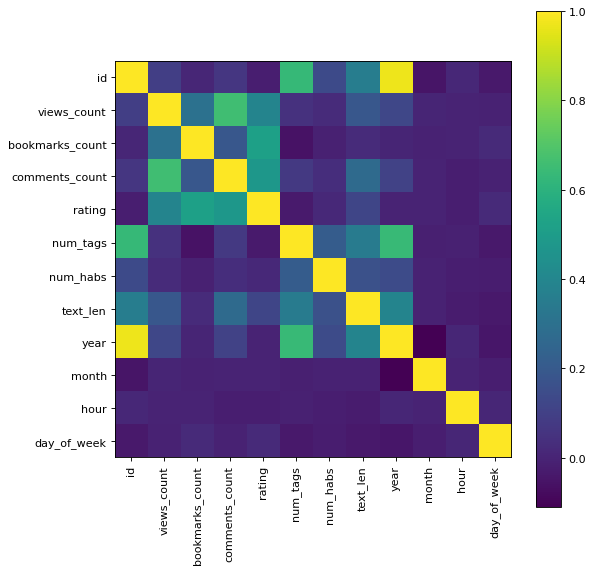

In [ ]:
plotCorrelationMatrix(preprocessed_posts, 8)

6 8


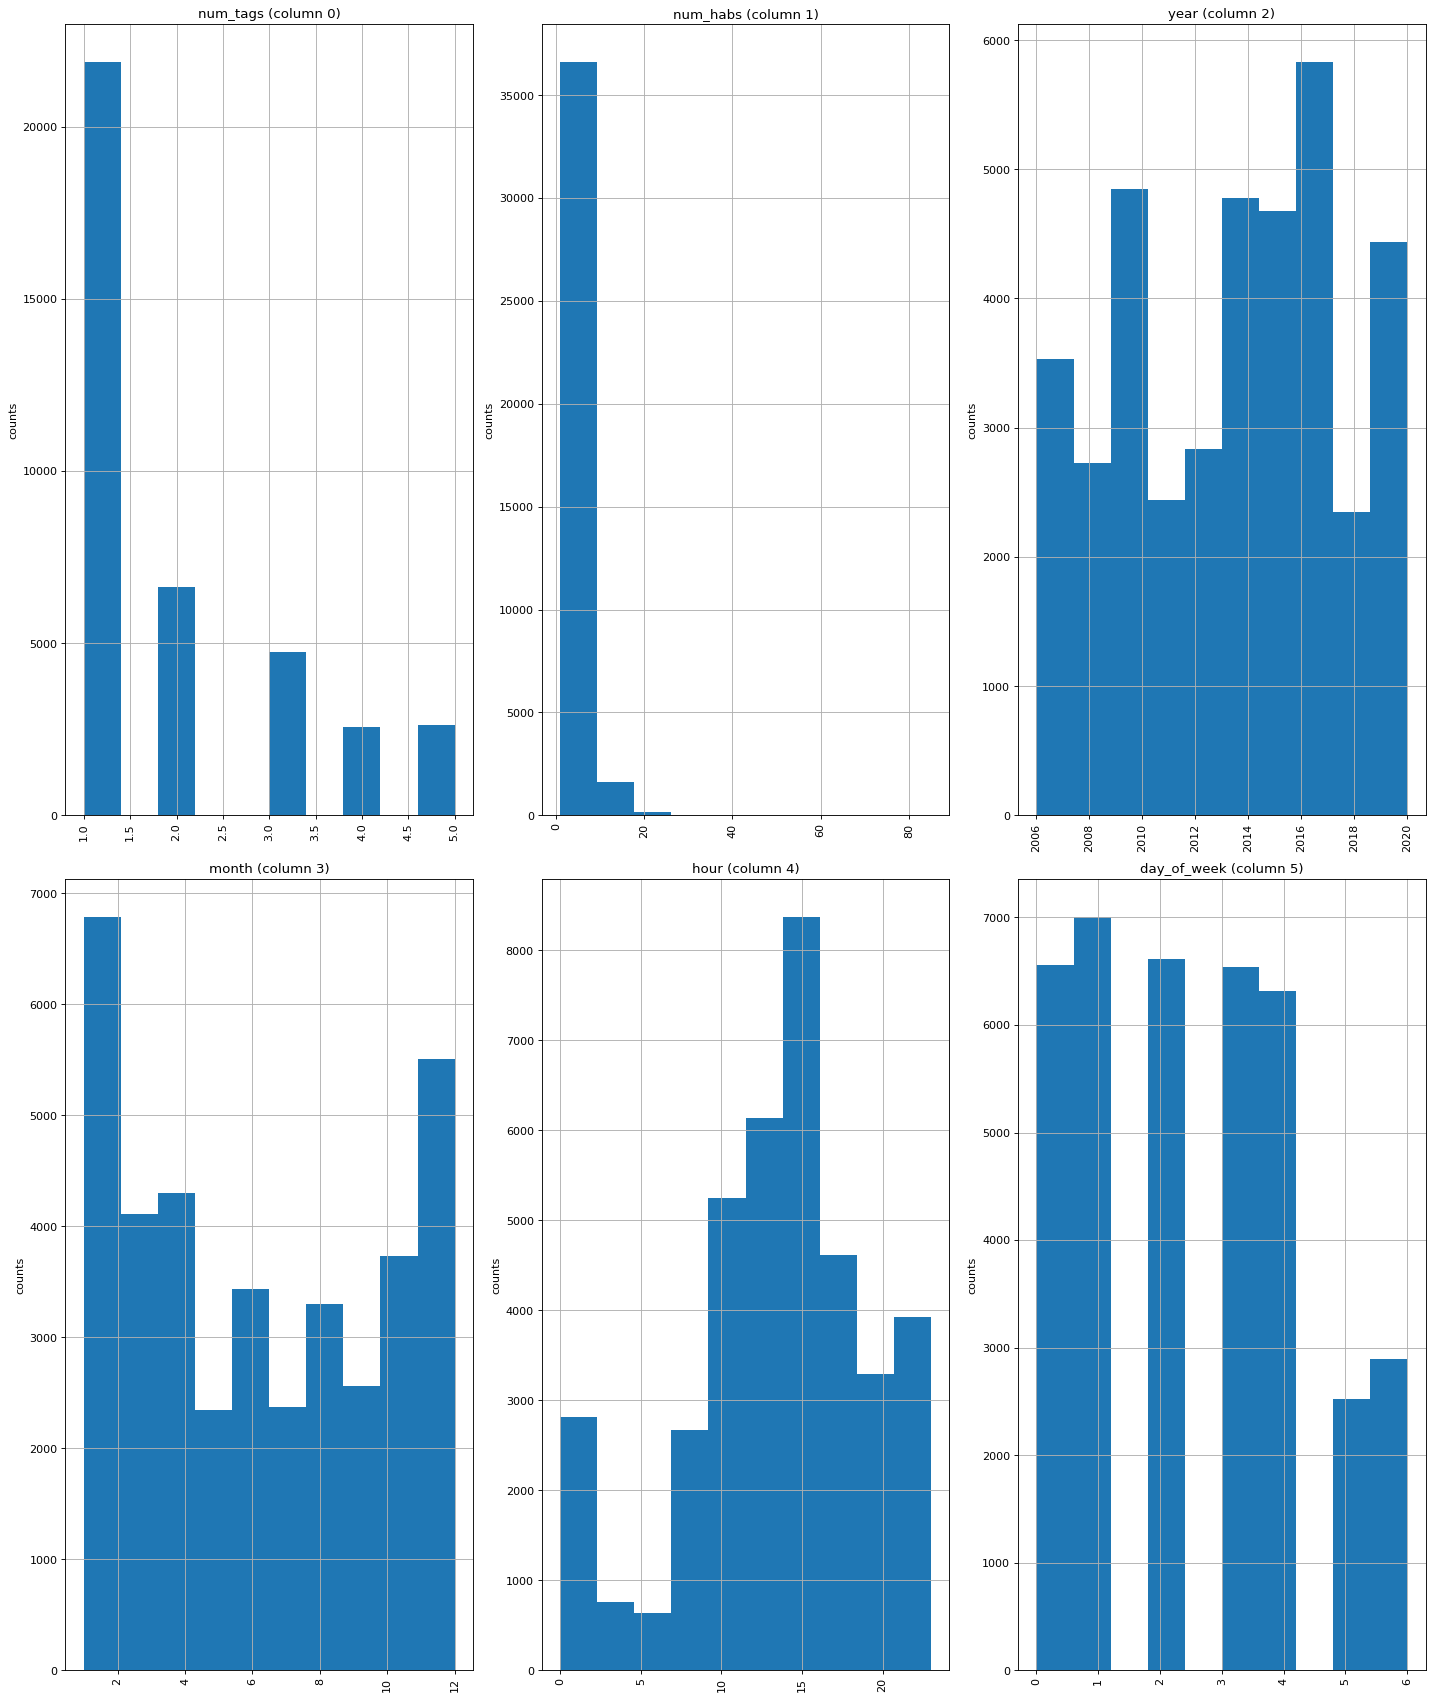

In [ ]:
plotPerColumnDistribution(preprocessed_posts, 8, 3)

#Statistical hypothesis testing#1 (correlation)

parametric criteria - Pearson's 

non-parametric criteria - Spearman's

H0: condition and result is **not** independent

H1: condition and result is independent

Significance level (alpha) = 0.05


Определение согласованности между:
{месяц/ час/ кол-ом тэгов/ кол-ом хабов/ длиной текстов/ день недели} vs {кол-ом просмотров/ оставленных комментариев/ рейтингом}

In [ ]:
#Функция, предоставляющая зависимость величин друг от друга
#Взята вместе с данными c несущественными изменениями

def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [ ]:
def correlation(condition, result):
    non_parametric = scipy.stats.spearmanr(condition, result)
    parametric = scipy.stats.pearsonr(condition, result)
    return  non_parametric, parametric

####month vs result

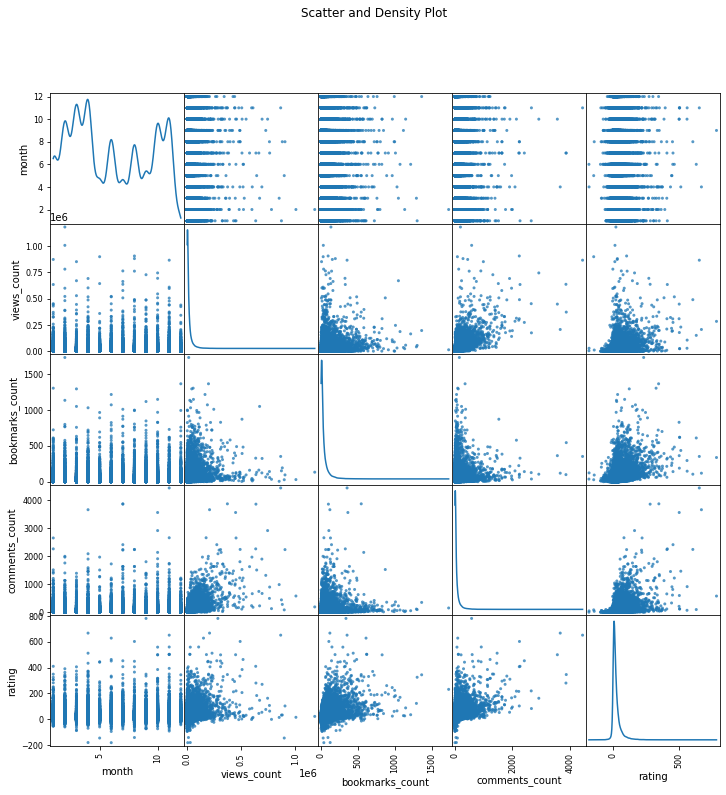

In [ ]:
temp = preprocessed_posts[["month", "views_count", "bookmarks_count", "comments_count", "rating"]]
plotScatterMatrix(temp, 12, 12)

In [ ]:
correlation(preprocessed_posts.month, preprocessed_posts.views_count)

(SpearmanrResult(correlation=-0.0020812897818425534, pvalue=0.6832272036445357),
 (0.004387984153964306, 0.3896108851544674))

In [ ]:
correlation(preprocessed_posts.month, preprocessed_posts.bookmarks_count)

(SpearmanrResult(correlation=-0.008299070937665182, pvalue=0.10370215852985226),
 (-0.0025390347734964335, 0.6186177679326231))

In [ ]:
correlation(preprocessed_posts.month, preprocessed_posts.comments_count)

(SpearmanrResult(correlation=-0.011790543719484764, pvalue=0.020790708430941014),
 (0.0019122571378217966, 0.7077182993078975))

In [ ]:
correlation(preprocessed_posts.month, preprocessed_posts.rating)

(SpearmanrResult(correlation=-0.010995244368305774, pvalue=0.03109771150419145),
 (-0.00172888895878676, 0.73463193274916))

Непараметрический критерий отверг H0 для month vs {comments_count, rating}.

Параметрический критерий не отверг ни одной H0.

####hour vs result

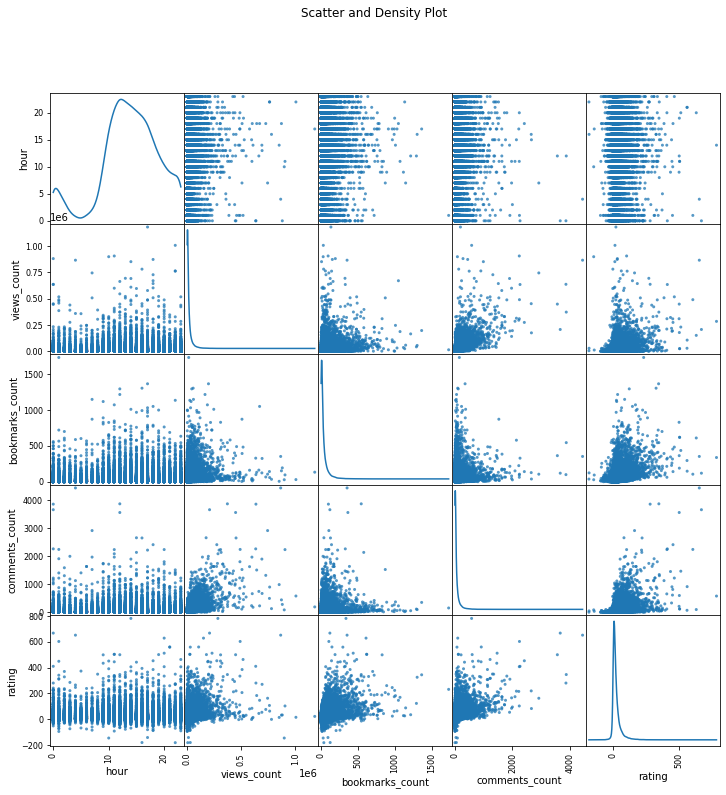

In [ ]:
temp = preprocessed_posts[["hour", "views_count", "bookmarks_count", "comments_count", "rating"]]
plotScatterMatrix(temp, 12, 12)

In [ ]:
correlation(preprocessed_posts.hour, preprocessed_posts.views_count)

(SpearmanrResult(correlation=-0.012615180929349105, pvalue=0.013381095936609562),
 (-0.0006355248188452877, 0.9008381770347951))

In [ ]:
correlation(preprocessed_posts.hour, preprocessed_posts.bookmarks_count)

(SpearmanrResult(correlation=0.018295332690444345, pvalue=0.0003340830693620694),
 (0.0011986190632211693, 0.8142053782610705))

In [ ]:
correlation(preprocessed_posts.hour, preprocessed_posts.comments_count)

(SpearmanrResult(correlation=-0.028275828960095062, pvalue=2.940583137133135e-08),
 (-0.017544702173075855, 0.0005814504073524617))

In [ ]:
correlation(preprocessed_posts.hour, preprocessed_posts.rating)

(SpearmanrResult(correlation=-0.008416728434183375, pvalue=0.09889509315049484),
 (-0.015645855858533713, 0.002156746511675939))

Непараметрический критерий отверг H0 для hour vs {views_count, bookmarks_count, comments_count, rating}.

Параметрический критерий отверг H0 для hour vs {comments_count, rating}.

####num_tags vs result

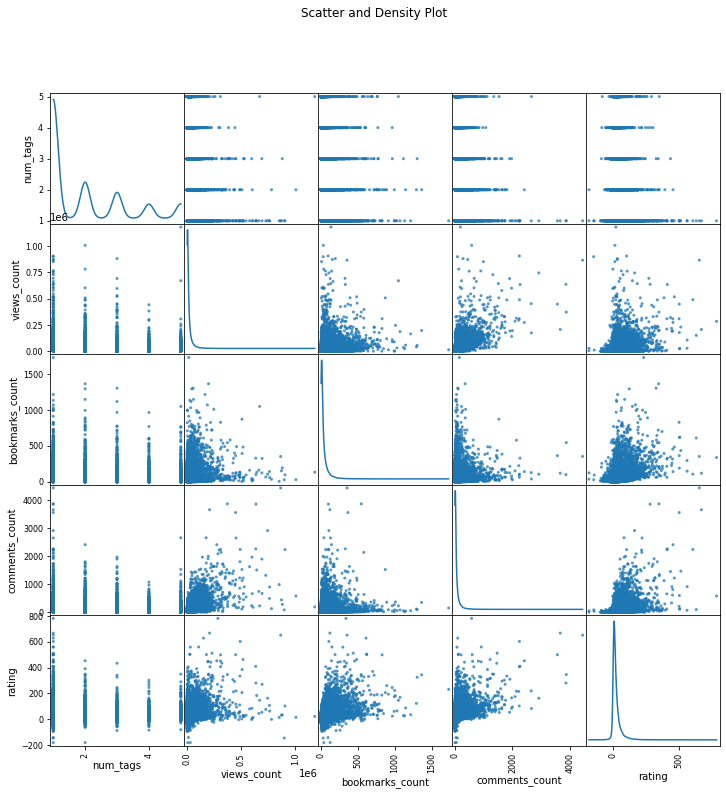

In [ ]:
temp = preprocessed_posts[["num_tags", "views_count", "bookmarks_count", "comments_count", "rating"]]
plotScatterMatrix(temp, 12, 12)

In [ ]:
correlation(preprocessed_posts.num_tags, preprocessed_posts.views_count)

(SpearmanrResult(correlation=0.3478822006139521, pvalue=0.0),
 (0.047867043340021634, 5.982152538101665e-21))

In [ ]:
correlation(preprocessed_posts.num_tags, preprocessed_posts.bookmarks_count)

(SpearmanrResult(correlation=-0.12789974504971008, pvalue=6.665911007052029e-140),
 (-0.056193420792868765, 2.8589110076242007e-28))

In [ ]:
correlation(preprocessed_posts.num_tags, preprocessed_posts.comments_count)

(SpearmanrResult(correlation=0.3463946753237505, pvalue=0.0),
 (0.07397208978630601, 8.656965513570384e-48))

In [ ]:
correlation(preprocessed_posts.num_tags, preprocessed_posts.rating)

(SpearmanrResult(correlation=0.07212427036159408, pvalue=1.6360192735688716e-45),
 (-0.03228959719752132, 2.4132992461714536e-10))

Непараметрический и параметрический критерии отвергли H0 для **num_tags vs {views_count, bookmarks_count, comments_count, rating}**.


####num_habs vs result

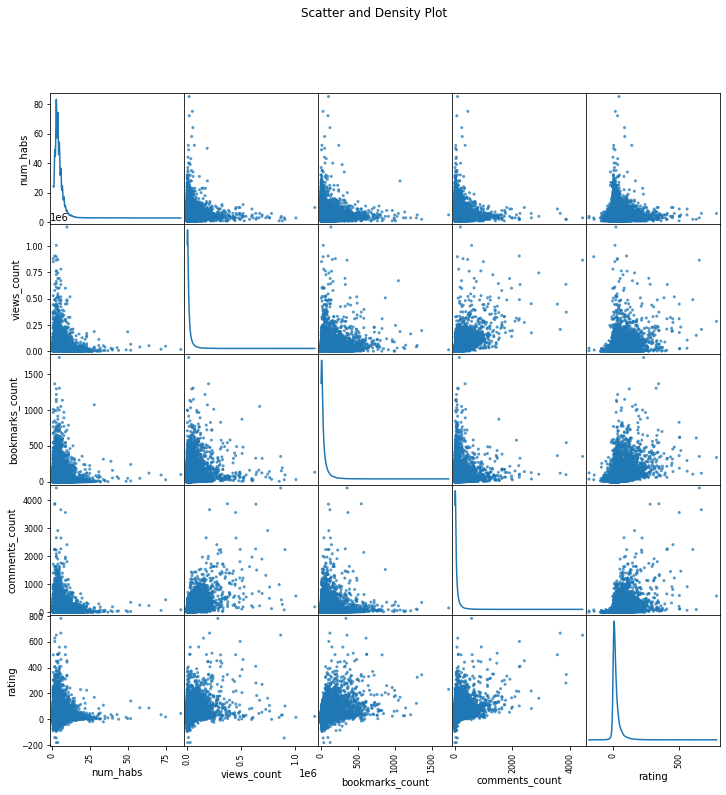

In [ ]:
temp = preprocessed_posts[["num_habs", "views_count", "bookmarks_count", "comments_count", "rating"]]
plotScatterMatrix(temp, 12, 12)

In [ ]:
correlation(preprocessed_posts.num_habs, preprocessed_posts.views_count)

(SpearmanrResult(correlation=0.08860001717432524, pvalue=7.51105834629184e-68),
 (0.027576507825793364, 6.382244942194674e-08))

In [ ]:
correlation(preprocessed_posts.num_habs, preprocessed_posts.bookmarks_count)

(SpearmanrResult(correlation=-0.034164680492301314, pvalue=2.0789502285601054e-11),
 (-0.008873881248791609, 0.08188193415549314))

In [ ]:
correlation(preprocessed_posts.num_habs, preprocessed_posts.comments_count)

(SpearmanrResult(correlation=0.08087961486663128, pvalue=8.246775507605736e-57),
 (0.03329717729974323, 6.570908597777912e-11))

In [ ]:
correlation(preprocessed_posts.num_habs, preprocessed_posts.rating)

(SpearmanrResult(correlation=0.052903663472715405, pvalue=3.067612906194032e-25),
 (0.0159816734969288, 0.0017267206341007825))

Непараметрический и параметрический критерии отвергли H0 для **num_habs vs {views_count, bookmarks_count, comments_count, rating}**.


####text_len vs result

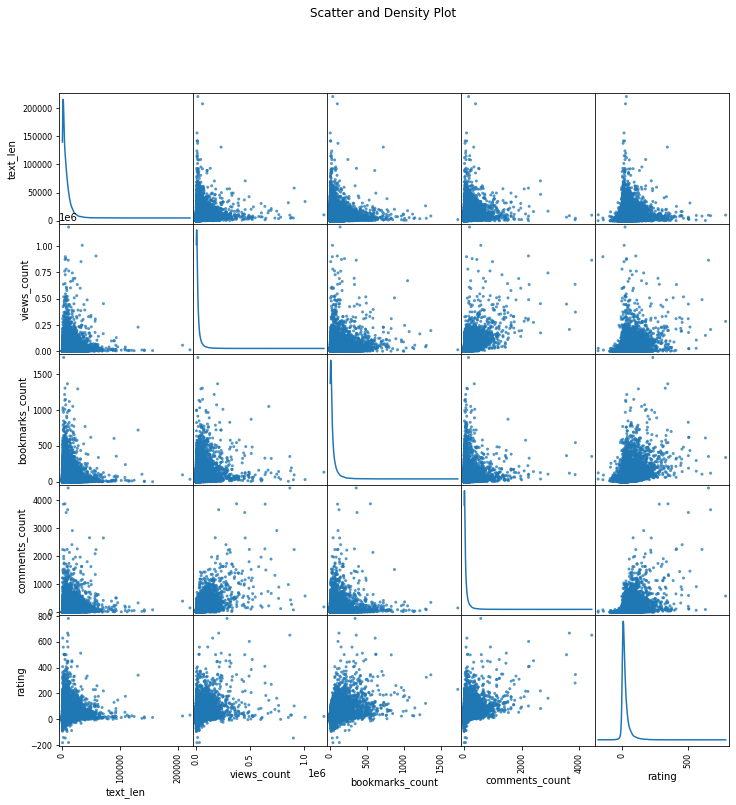

In [ ]:
temp = preprocessed_posts[["text_len", "views_count", "bookmarks_count", "comments_count", "rating"]]
plotScatterMatrix(temp, 12, 12)

In [ ]:
correlation(preprocessed_posts.text_len, preprocessed_posts.views_count)

(SpearmanrResult(correlation=0.5255492376103734, pvalue=0.0),
 (0.1916825175975208, 7.081938934e-315))

In [ ]:
correlation(preprocessed_posts.text_len, preprocessed_posts.bookmarks_count)

(SpearmanrResult(correlation=0.03124593616172846, pvalue=8.918533033544141e-10),
 (0.026242370812514133, 2.660558785448205e-07))

In [ ]:
correlation(preprocessed_posts.text_len, preprocessed_posts.comments_count)

(SpearmanrResult(correlation=0.6238817929725057, pvalue=0.0),
 (0.2729307528405226, 0.0))

In [ ]:
correlation(preprocessed_posts.text_len, preprocessed_posts.rating)

(SpearmanrResult(correlation=0.22473145546208462, pvalue=0.0),
 (0.12337373722791115, 3.054349414057768e-130))

Непараметрический и параметрический критерии отвергли H0 для **text_len vs {views_count, bookmarks_count, comments_count, rating}**.


####day_of_week vs result

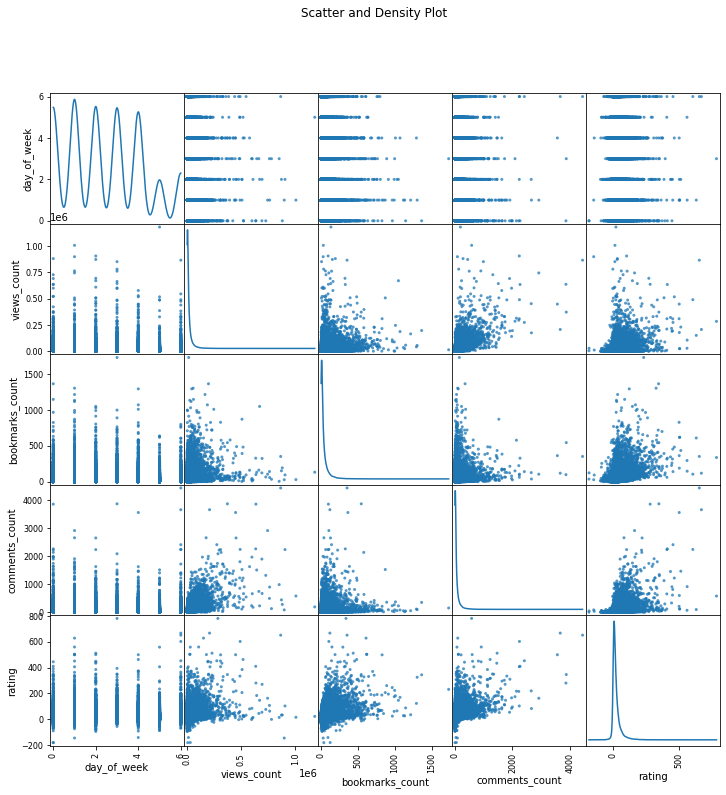

In [ ]:
temp = preprocessed_posts[["day_of_week", "views_count", "bookmarks_count", "comments_count", "rating"]]
plotScatterMatrix(temp, 12, 12)

In [ ]:
correlation(preprocessed_posts.day_of_week, preprocessed_posts.views_count)

(SpearmanrResult(correlation=-0.015450375632952996, pvalue=0.0024502384955479633),
 (-0.003015035446955957, 0.5544288309838147))

In [ ]:
correlation(preprocessed_posts.day_of_week, preprocessed_posts.bookmarks_count)

(SpearmanrResult(correlation=0.04338917361144226, pvalue=1.7244354280565094e-17),
 (0.02303353469471895, 6.283708865187489e-06))

In [ ]:
correlation(preprocessed_posts.day_of_week, preprocessed_posts.comments_count)

(SpearmanrResult(correlation=-0.013598769451008163, pvalue=0.007668395083433255),
 (-0.002729729740126815, 0.5925125294593448))

In [ ]:
correlation(preprocessed_posts.day_of_week, preprocessed_posts.rating)

(SpearmanrResult(correlation=0.010010010850661564, pvalue=0.04968838935733514),
 (0.020696886498366523, 4.942748215902897e-05))

Непараметрический критерий отверг H0 для **day_of_week vs {views_count, bookmarks_count, comments_count, rating}**.

Параметрический критерий отверг H0 для **day_of_week vs {bookmarks_count, rating}**.

####end_srochastic#1

#Statistical hypothesis testing#2

Check if distribution of published articles regarding on hour of publication is normal or not.

parametric criteria - Shapiro–Wilk's

non-parametric criteria - Lilliefors's 

H0: distribution is **normal**

H1: Ho is wrong

Significance level (alpha) = 0.05


(38443, 1)
1 8


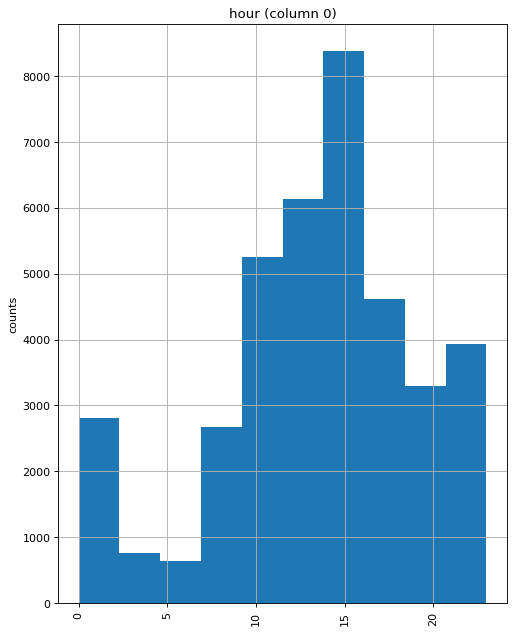

In [ ]:
hour_df = pd.DataFrame(preprocessed_posts["hour"])
plotPerColumnDistribution(hour_df, 8, 3)

Можно заметить, что 0-3 часы сдвинуты. Я предполагаю, что это может из-за того, что московское время сохранения отличется от международого, из-за чего мог возникнуть такой сдвиг, поэтому я тоже свиднул время на 3 часа. Получилось вот так:

In [ ]:
hour_df = pd.DataFrame(preprocessed_posts["hour"])
hour_df["hour"] = (hour_df.hour - 4) % 24
hour_df = hour_df.value_counts()
hour_df = hour_df.sort_index()
hour_df

hour
0        329
1        272
2        364
3        461
4        715
5       1497
6       2399
7       2848
8       3138
9       2993
10      2908
11      2786
12      2677
13      2511
14      2101
15      1765
16      1522
17      1341
18      1300
19      1285
20      1202
21       921
22       684
23       424
dtype: int64

####Parametric

In [ ]:
stats.shapiro(hour_df)

(0.9127958416938782, 0.040572211146354675)

####Non-parametric

In [ ]:
lilliefors(hour_df)

(0.12589139053732845, 0.2)

####Conclusion Statistical hypothesis testing#2

Оба критерия дают результат, что распределение не является нормальным.

#Time series prediction

Были рассмотрен временной ряд зависимост кол-ва статей, вышедших за один на протяжении всего временногго отрезка. Этот результат будет экстраполирован на ближайшие 10 дней.

In [ ]:
c = pd.to_datetime(original_habr_posts.date, format='%Y-%m-%d %H:%M:%S')
temp1 = pd.DataFrame(original_habr_posts["date"])
temp1["date"] = pd.DataFrame(c.dt.strftime('%Y-%m-%d'))

temp1 = temp1.groupby(['date']).size().reset_index(name='counts')

temp1

,date,counts
0,2006-06-24,1
1,2006-06-28,2
2,2006-06-30,4
3,2006-07-01,2
4,2006-07-03,1
...,...,...
3043,2020-06-16,2
3044,2020-06-17,1
3045,2020-06-19,2
3046,2020-06-22,1


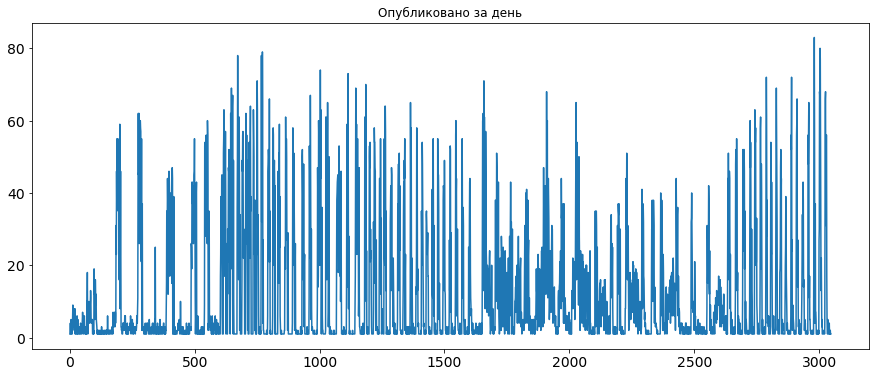

In [ ]:
temp1.counts.plot( figsize=(15,6),title= 'Опубликовано за день', fontsize=14)

In [ ]:
def rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
train = temp1[:-7]
len(train), len(temp1)

(3041, 3048)

In [ ]:
#по последним n дням
n = 31
mine = np.array([])
for i in range(7):
    mine_cur = np.mean(train[-25 + i:])
    if(len(mine) != 0):
        mine = np.array(mine_cur)
    else:
        mine = np.concatenate(mine, np.array([mine_cur]))
mine

TypeError: ignored


#Conlusion

В результате проверки статических гипотез было выводено, что большинство показателей "выкладывания" не влияют на её успешность. Можно только сказать, что длина написанного текста влияет соотносится с количеством оставленных комментариев, что и логично, так как если статья больше, то больше есть про что можнно оставить комментарий.